**Подключение библиотек**

In [ ]:
! pip install pytorch_lightning
! pip install segmentation-models-pytorch

In [ ]:
import torch
import numpy as np
import albumentations as albu
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import os
from matplotlib.pyplot import imshow
from PIL import Image
import random

In [ ]:

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.io import read_image
import torchvision.transforms as T
import torchmetrics
# import albumentations

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 500
import matplotlib.image as mpimg
import pandas as pd

import os
import glob
from os import path
from pathlib import Path
from tqdm import tqdm

import cv2
from PIL import Image, ImageFile

In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

Подгрузим данные и создадим датасет

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Codes(torch.utils.data.Dataset):
  def __init__(self, split = 'train', num_classes = 2):
    super().__init__()
    self.image_dir = '/content/drive/MyDrive/courswork/barcode/pic'
    self.mask_dir = '/content/drive/MyDrive/courswork/barcode/segmentation'
    self.mask_names = os.listdir(self.mask_dir)
    self.mode = split

    self.aug = self.get_training_transform()
    self.post_transform = torchvision.transforms.ToTensor()
    self.num_classes = num_classes
  
  def __len__(self):
    return len(self.mask_names)

  def __getitem__(self, item):
    image = Image.open(os.path.join(self.image_dir, self.mask_names[item])).convert("RGB")
    mask = Image.open(os.path.join(self.mask_dir, self.mask_names[item])).convert("1")

    image = transforms.Resize((416, 416))(image)
    mask = transforms.Resize((416, 416))(mask)

    image = np.array(image)
    mask = np.array(mask).astype(np.int64)

    if self.mode == 'train':
      transformed = self.aug(image=image, mask=mask)
      image, mask = transformed['image'], transformed['mask']

    image = self.post_transform(image)

    return image, mask

  def get_training_transform(crop = (70, 70)):
    train_transform = [
        # albu.PadIfNeeded(
        #     min_height=1024,
        #     min_width=1024,
        #     border_mode=cv2.BORDER_CONSTANT,
        #     always_apply=True,
        #     mask_value=255,
        #     value=0,
        # ),
        albu.RandomRotate90(p=1),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        # albu.RandomCrop(300, 300),
        albu.ChannelShuffle(),
    ]
    return albu.Compose(train_transform)

In [ ]:
tmp = Codes()

In [ ]:
tmp.__len__()

179

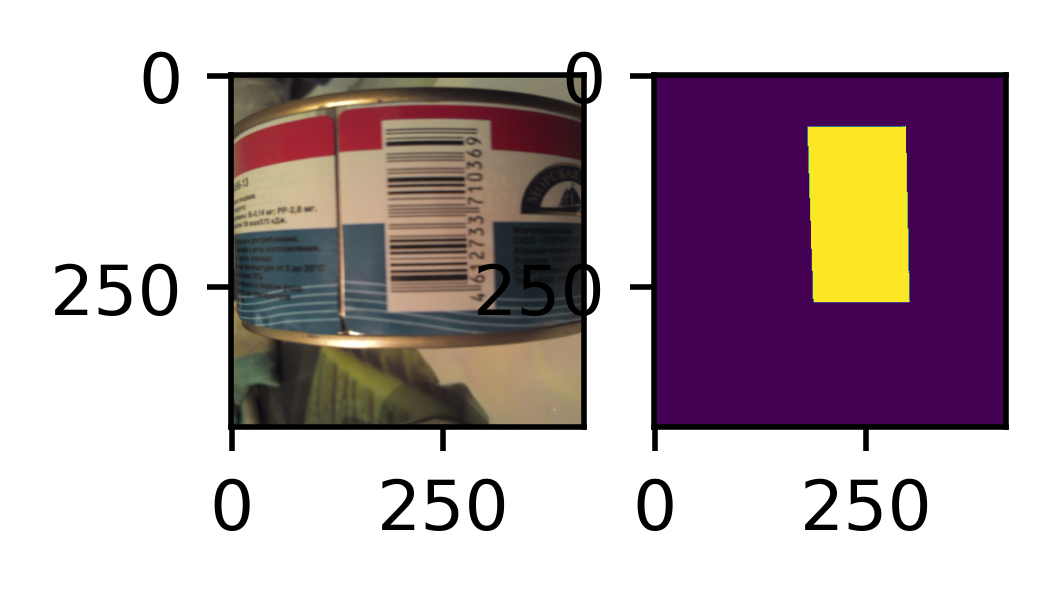

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(2, 6))

b = tmp.__getitem__(1)
axes[0].imshow(b[0].permute(1, 2, 0))
axes[1].imshow(b[1])

Напишем лоссы

# Новый раздел

In [ ]:
class DiceLoss(nn.Module):
  def __init__(self, eps = 1e-7):
    super().__init__()
    self.eps = eps

  def forward(self, inputs, targets):

    inputs = torch.nn.functional.softmax(inputs)
    targets = torch.nn.functional.one_hot(targets).permute(0, 3, 1, 2)

    inputs = inputs.view(-1)
    targets = targets.contiguous().view(-1)


    inter = (inputs * targets).sum()
    union = inputs.sum() + targets.sum()

    dice = (2*inter) / (union + self.eps)


    return 1 - dice


class IoULoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super().__init__()

  def forward(self, inputs, targets, smooth=1):
        
    inputs = torch.nn.functional.softmax(inputs)
    targets = torch.nn.functional.one_hot(targets).permute(0, 3, 1, 2)    
        
    inputs = inputs.view(-1)
    targets = targets.contiguous().view(-1)
        
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
        
    IoU = (intersection + smooth)/(union + smooth)
                
    return 1 - IoU    


class BCEDiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.bce = nn.BCEWithLogitsLoss()
    self.dice = DiceLoss()

  def forward(self, inputs, targets):
    dice_loss = self.dice(inputs, targets)
    bce_loss = self.bce(inputs, targets)
    
    return bce_loss + dice_loss


class JaccardBCELoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.bce = nn.BCEWithLogitsLoss()
    self.jaccard = IoULoss()

  def forward(self, inputs, targets):
    jaccard_loss = self.jaccard(inputs, targets)
    bce_loss = self.bce(inputs, targets)
    
    return bce_loss + jaccard_loss

class FocalLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, inputs, targets, alpha=0.8, gamma=2.0, smooth=1):

    inputs = torch.nn.functional.softmax(inputs)
    targets = torch.nn.functional.one_hot(targets).permute(0, 3, 1, 2)

    BCE = nn.functional.binary_cross_entropy(inputs, targets)
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha*(1-BCE_EXP)**gamma * BCE

    return focal_loss

class JaccardDiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.dice = DiceLoss()
    self.jaccard = IoULoss()

  def forward(self, inputs, targets):
    jaccard_loss = self.jaccard(inputs, targets)
    dice_loss = self.dice(inputs, targets)

    return dice_loss + jaccard_loss

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from operator import add

def calculate_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    y_pred = y_pred.cpu().numpy()
    y_pred_auc = y_pred.reshape(-1)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    specificity = tn / (tn+fp)
    sensitivity = tp / (tp + fn)
    score_auc = roc_auc_score(y_true, y_pred_auc)
    score_f1 = 2*tp/(2*tp+fn+fp) 
    score_acc = (tp + tn) / (tp + tn + fn + fp)

    return [specificity, sensitivity, score_auc, score_f1, score_acc]

визуализируем маски

In [ ]:
def visualize_masks(true, pred, image): #для валидации
    fig, ax = plt.subplots(1, 3, figsize=(15, 45))
    ax[0].imshow(true)
    ax[1].imshow(pred)
    ax[2].imshow(image.permute(1, 2, 0))
    plt.show()

In [ ]:
def visualize(pred, image): #для теста
    fig, ax = plt.subplots(1, 2, figsize=(15, 30))
    ax[1].imshow(pred)
    ax[2].imshow(image.permute(1, 2, 0))
    plt.show()

обучение

In [ ]:

MODELS = {
    "pretrain-unet": smp.Unet,
    "pretrain-deeplab": smp.DeepLabV3,
    "pretrain-fpn" : smp.FPN,
    "pretrain-psp" : smp.PSPNet

}

CRITERIONS = {
    "ce": torch.nn.CrossEntropyLoss(),
    "dice": DiceLoss(),
    "iou": IoULoss()
}

class SegCodes(pl.LightningModule):
  def __init__(self, config):
        super().__init__()
        self.save_hyperparameters()
        self._config = config
        self.model = MODELS[config["model_type"]](**config["model_params"])
        self.criterion = CRITERIONS[config["criterion_type"]]
        self.iou = IoULoss()

  def get_dataset(self, split="train"):
        return Codes(split = split, num_classes=self._config["model_params"]["classes"])

  def train_dataloader(self):
        dataset = self.get_dataset(split="train")
        params = self._config["dataset_params"]
        return torch.utils.data.DataLoader(
            dataset, params["batch_size"], num_workers=8, shuffle=True,
        )
    
  def test_dataloader(self):
        dataset = self.get_dataset(split="test")
        params = self._config["dataset_params"]
        return torch.utils.data.DataLoader(
            dataset, batch_size = params["batch_size"], num_workers=8, shuffle=False
        )

  def val_dataloader(self):
        dataset = self.get_dataset(split="val")
        params = self._config["dataset_params"]
        return torch.utils.data.DataLoader(
            dataset, batch_size = params["batch_size"], num_workers=8, shuffle=False
        )

  def configure_optimizers(self):
        params = self._config["optimizer_params"]
        optimizer = torch.optim.Adam(self.model.parameters(), **params)
        return optimizer

  def training_step(self, batch, batch_idx):
        images, labels = batch
        predicted_heatmaps = self.model(images)
        loss = self.criterion(predicted_heatmaps, labels)

        # predicted_masks = torch.argmax(predicted_heatmaps, dim=1)
        # pred = predicted_masks.detach().cpu()[0]
        # true = labels.detach().cpu()[0]
        # image = images[0].detach().cpu()
        # visualize_masks(true, pred, image)

        self.log("loss", loss)
        return {"loss": loss}
    
  def test_step(self, batch, batch_idx):
      images, labels = batch
      predicted_heatmaps = self.model(images)
      loss = self.criterion(predicted_heatmaps, labels)
      self.log("test_loss", loss)

      predicted_masks = torch.argmax(predicted_heatmaps, dim=1)
      pred = predicted_masks.detach().cpu()[0]
      true = labels.detach().cpu()[0]
      image = images[0].detach().cpu()
      visualize_masks(true, pred, image)

      specificity, sensitivity, score_auc, score_f1, score_acc = calculate_metrics(true, pred)


      iou = self.iou(predicted_heatmaps, labels)
      # iou = compute_iou(predicted_masks.detach().cpu(), labels.detach().cpu())
      self.log("test_iou", iou)

      return {"test_loss": loss, "test_iou": iou, "specificity": specificity, "sensitivity": sensitivity,
              "score_auc": score_auc, "score_f1":score_f1, "score_acc":score_acc}
  
  def validation_step(self, batch, batch_idx):
      images, labels = batch
      predicted_heatmaps = self.model(images)
      loss = self.criterion(predicted_heatmaps, labels)
      self.log("val_loss", loss)
      # predicted_masks = torch.argmax(predicted_heatmaps, dim=1)
      iou = self.iou(predicted_heatmaps, labels)
      self.log("val_iou", iou)
      return {"val_loss": loss, "val_iou": iou}

In [ ]:
# All logs here.
%reload_ext tensorboard
%tensorboard --logdir logs/

In [ ]:
## DEEPLAB

In [ ]:
config = {
    "model_type": "pretrain-deeplab", #"pretrain-deeplab", "pretrain-unet"
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "iou",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()

In [ ]:
config = {
    "model_type": "pretrain-deeplab", #"pretrain-deeplab", "pretrain-unet"
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "dice",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()

In [ ]:
# UNET

In [ ]:

config = {
    "model_type": "pretrain-unet",
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "iou",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()

In [ ]:

config = {
    "model_type": "pretrain-unet",
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "dice",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()

In [ ]:

config = {
    "model_type": "pretrain-fpn",
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "iou",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()

In [ ]:

config = {
    "model_type": "pretrain-fpn",
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "dice",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()

In [ ]:
config = {
    "model_type": "pretrain-psp", #"pretrain-deeplab", "pretrain-unet"
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "iou",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()

In [ ]:
config = {
    "model_type": "pretrain-psp", #"pretrain-deeplab", "pretrain-unet"
    "model_params": {
        "classes": 2,
        "encoder_name": 'resnet101',
        "encoder_weights": "imagenet",
        "activation": None
    },
    "criterion_type": "dice",
    "optimizer_params": {
        "lr": 0.0001
    },
    "dataset_params": {
        "batch_size": 8,
    }
}
module = SegCodes(config)
logger = pl.loggers.TensorBoardLogger("./logs", name='dice')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=20,
    default_root_dir="/content/"
)
trainer.fit(module)
trainer.test()